In [1]:
#딥러닝을 해킹하는 적대적 공격
#딥러닝 모델의 착시를 유도해서 정확도를 떨어뜨려 보안문제를 일으키는것
#adversarial attack
#픽셀 하나만 바꿔도 아예 다르게 예측할 수 있음
#모델의 정보를 토대로 잡음을 생성하는 화이트박스 방법, 모델 정보 없이 생성하는 블랙박스로 나뉨
#원하는 정답으로 유도가 가능하면 표적, 아니라면 비표적 이라고 함
#잡음을 생성하기 위해 반복학습이 필요하면 반복, 아니면 원샷이라고 함
#특정 입력에만 적용되는지, 모든 이미지에 적용될 수 있는 범용적인 잡음인지로 나눌 수 있음
#대표적인 적대적 공격으로 FGSM (fast gradient sign method)를 사용하여 적대적 예제를 생성할 수 있음

import torch
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms

from PIL import Image
import json
import matplotlib.pyplot as plt

#토치비전은 AlexNet, VGG, ResNet, SqueezeNet, DenseNet, inception 등 여러가지 학습된 모델을 제공함
#학습된 모델을 사용하고 싶으면 사용할 모델을 가져오는 models.<모델명> 을 호출할 때 pretrained=True를 사용하면 학습이 완료된 모델을 사용할 수 있음
model = models.resnet101(pretrained = True)
model.eval()

/home/hyunskki/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/hyunskki/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /home/hyunskki/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [4]:
#클래스 사람이 볼 수 있게 변환
CLASSES = json.load(open('./imagenet_samples/imagenet_classes.json'))
idx2class = [CLASSES[str(i)] for i in range(1000)]
#공격할 이미지 불러오기
img = Image.open('imagenet_samples/corgie.jpg')
# 이미지 크기 변환
img_transforms = transforms.Compose([transforms.Resize((224,224),Image.BICUBIC),transforms.ToTensor(),])
img_tensor = img_transforms(img)
img_tensor = img_tensor.unsqueeze(0)

print('이미지 텐서 shape : ',img_tensor.size())

이미지 텐서 shape :  torch.Size([1, 3, 224, 224])


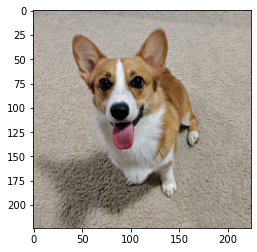

In [5]:
#원본 이미지 텐서의 시각화를 위해서 squeeze 함수로 차원을 줄이고 detach함수로 원본 이미지텐서와의 연결을 끊는다. 또한 transpose함수로
#뒤집힌 이미지를 돌려놓고 맷플롯립 라이브러리와 호환하는 넘파이로 만들기 위해서 numpy를 사용함
original_img_view = img_tensor.squeeze(0).detach()
original_img_view = original_img_view.transpose(0,2).transpose(0,1).numpy()
plt.imshow(original_img_view)

In [6]:
#모델이 데이터셋에 없는 이미지를 얼마나 잘 분류하는지 확인하기
output = model(img_tensor)
prediction = output.max(1,keepdim=False)[1] # max를 이용하여 가장 확률이 높은 것 출력

prediction_idx = prediction.item()
prediction_name = idx2class[prediction_idx]

print('예측 레이블 번호', prediction_idx)
print('예측 레이블 이름', prediction_name)
#정확하게 웰시코기를 예측함


예측 레이블 번호 263
예측 레이블 이름 Pembroke, Pembroke Welsh corgi


In [9]:
#FGSM의 핵심은 모델에서 입력 이미지에 대한 기울기 정보를 추출하고 왜곡하여 이미지에 더해주는 것임
# 오차를 줄이는 것이 아니라 오차를 키워줌
def fgsm_attack(image,epsilon,gradient):
    #기울기값의 원소의 sign값
    sign_gradient = gradient.sign()
    # sign쪽으로 epsilon만큼 조절
    perturbed_image = image + epsilon * sign_gradient
    #[0,1] 범위 벗어나는 값 조절
    perturbed_image = torch.clamp(perturbed_image,0,1)
    return perturbed_image

#적대적 예제 생성

#원본 이미지에 대한 기울기를 추출하려면 requires_grad_(True)함수를 호출해 기울기를 보존하도록 명시해야함

#이미지의 기울기 구하도록 설정
img_tensor.requires_grad_(True)
#이미지를 모델에 통과
output = model(img_tensor)

loss = F.nll_loss(output,torch.tensor([263]))

#기울기 구하기
model.zero_grad()
loss.backward()

#역전파를 마치고 나면 img_tensor 의 grad.data 변수에 기울기가 저장됨

#이미지의 기울기 추출
gradient = img_tensor.grad.data
epsilon = 0.03
perturbed_data = fgsm_attack(img_tensor,epsilon, gradient)

output = model(perturbed_data)

prediction = output.max(1,keepdim=False)[1]
prediction_idx = prediction.item()
prediction_name = idx2class[prediction_idx]

print(prediction_name)

# whippet으로 예측함 

whippet
